In [1]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd

# Global variable initialization and error checking - ok

In [2]:
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900 
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0,0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node
                        #1  2  3   4   5  6   7   8      9    10   11   12   13
Delay_VoltageSampling = np.array([0,0,0,0,0,10,10,10,10,10,10,10,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0,60,60,60,60,60,60,60,60,60,60,60,60,60,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')


Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


# Load data from file

In [3]:
#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

Reading Data for Pecan Street is done.


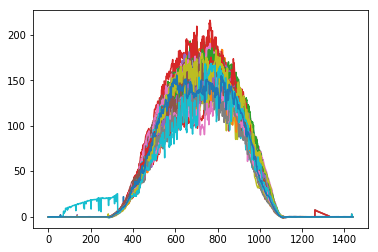

In [4]:
for i in range(Generation.shape[1]):
    plt.plot(Generation[:,i])
plt.show()

# Interpolate to change data from minutes to seconds - ok

In [5]:
from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds

#Create noise vector
Noise = np.empty([TotalTimeSteps, TotalLoads])
for node in range(TotalLoads):
    Noise[:,node] = np.random.randn(TotalTimeSteps) 

#Add noise to loads
for node in range(TotalLoads):
    Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

if NoiseMultiplyer > 0:
    print('Load Interpolation has been done. Noise was added to the load profile.') 
else:
    print('Load Interpolation has been done. No Noise was added to the load profile.') 
    
MaxGenerationPossible = np.max(Generation, axis = 0)
sbar = MaxGenerationPossible

Starting Interpolation...
Load Interpolation has been done. No Noise was added to the load profile.


# Useful Functions

In [6]:
def inverter_qp_injection(counter, Vk, Vkm1, gammakm1,solar_irr,VBP,Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

# Testing Agent

Here we have 5 episodes, running through it
- Now testing to have it put to buffer
- TODO: rethink of reward function
- TODO: VAE to encode signals

In [18]:
totalPoints = []
for ep in range(5):
    print("episode:", ep)
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = 0
    terminal = False
    executeAction = False

    controlInv = 7
    
    #init action
    oldAction = []
    action = None

    #init state
    oldState = []
    state = []

    #init reward
    reward = None
    addBuffer = True
    
    points = 0
    
    for timeStep in range(TotalTimeSteps):
        VBPcounter += 1 
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                #adding P Q
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
        #############################################################
        #############################################################
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]* (1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])


        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1

                        #get State
                        if inverters[controlInv][0] is inverter:
                            length = Delay_VBPCurveShift[controlInv]
                            if VBPcounter == Delay_VBPCurveShift[controlInv] or terminal == True:
                                if terminal == False:
                                    length = Delay_VBPCurveShift[controlInv]
                                    V = nodes[controlInv].loc['Voltage',timeStep-length+1:timeStep]
                                    G = inverter.loc['Generation', timeStep-length+1:timeStep] 
                                    L = Load[timeStep-length+1:timeStep+1, node]
                                else:
                                    addBuffer = False
                                    length = VBPcounter
                                    V = nodes[controlInv].loc['Voltage',timeStep-length+1:]
                                    G = inverter.loc['Generation', timeStep-length+1:]
                                    L = Load[timeStep-length+1:, node]
                                    #print(V.shape, G.shape, L.shape)
                                    
                                oldState = state
                                #state = np.array([V - np.mean(V),G - np.mean(G)]).T
                                state = np.array([V, G, L]).T
                                #reset VBPcounter
                                VBPcounter = 0
                                #execute action                        
                                oldAction = copy.deepcopy(action)
                                #get action from Agent
                                #get sample action
                                #point13 = np.random.rand(2,)
                                #point24 = point13 + np.random.rand(2,)
                                if addBuffer == True:
                                    action = actor.model.predict(state.reshape([1, 60, 3]))[0]
                                    action[1] += action[0]
                                    action[3] += action[2]
                                    #print(action)
                                    #set VBP
                                    for k in range(timeStep, TotalTimeSteps):
                                        inverter.at['VBP',k] = copy.deepcopy(action)
                                
                                #reward
                                #caculate yk for that inverter
                                inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                reward = - sum(numberYks**2)
                                
                                #sum of reward for that ep
                                points += reward
                                
                                if oldAction != [] and oldState != [] and addBuffer == True:
                                    #push exp to buffer
                                    buffer.add(oldState, oldAction, reward, terminal, state)
                        
                        y_b = np.empty(BATCH_SIZE) 
                        #################################################
                        if buffer.size() > BATCH_SIZE:
                            s_b, a_b, r_b, t_b, s2_b = buffer.sample_batch(BATCH_SIZE)
                            target_ac = actor.target_model.predict(s2_b)
                            target_q = critic.target_model.predict([s2_b, target_ac.reshape([BATCH_SIZE, 1, 4])])
                            
                            
                            for k in range(BATCH_SIZE):
                                if t_b[k]:
                                    y_b[k] = rewards[k]
                                else:
                                    y_b[k] = r_b[k] + GAMMA * target_q[k,0,0]
                                    
                            y_b = y_b.reshape(BATCH_SIZE, 1, 1)
                            
                            critic.model.train_on_batch([s_b,a_b.reshape([BATCH_SIZE, 1, 4])], y_b)
                            a_for_grad = actor.model.predict(s_b)
                            grads = critic.gradients(s_b, a_for_grad.reshape([BATCH_SIZE, 1, 4]))                            
                            actor.train(s_b, grads)
                            actor.target_train()
                            critic.target_train()
                        #################################################
                        
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])

                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]
                        
    print(points)
    totalPoints.append(points)
    x = inverters[7][0].loc['VBP']
    y=np.zeros([len(x),x[0].shape[0]])
    for i in range(len(x)):
        y[i,:] = x[i]
        
    f = plt.figure()
    f.set_figheight(2)
    f.set_figwidth(20)
    f.add_subplot(1,3,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    f.add_subplot(1,3,2)
    plt.plot(y)
    f.add_subplot(1,3,3)
    plt.plot(totalPoints)
    plt.show(block=True)
    #fig, ax = plt.subplots(figsize=(20, 10))
    #ax.plot(nodes[7].loc['Voltage'], marker='o',  markersize=2)
    #ax.scatter(list(range(0,TotalTimeSteps,60)) ,nodes[7].loc['Voltage'][0::60], marker='o', color='red')
    #plt.show()
    

episode: 0
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
[[[-0.30069855]]

 [[-0.30070135]]]
[[[-0.30353168]]

 [[-0.30361086]]]
[[[-0.30636978]]

 [[-0.3064561 ]]]
[[[-0.3093121 ]]

 [[-0.30921975]]]
[[[-0.31209436]]

 [[-0.31208152]]]
[[[-0.31497484]]

 [[-0.31508717]]]
[[[-0.3179144 ]]

 [[-0.31803435]]]
[[[-0.32098836]]

 [[-0.32086095]]]
[[[-0.32395074]]

 [[-0.32386485]]]
[[[-0.32677945]]

 [[-0.32692257]]]
[[[-0.32990497]]

 [[-0.32981378]]]
[[[-0.33274525]]

 [[-0.3328988 ]]]
[[[-0.33574656]]

 [[-0.33590513]]]
[[[-0.338825  ]]

 [[-0.33876073]]]
[[[-0.3419485]]

 [[-0.3417801]]]
[[[-0.34480414]]

 [[-0.34487778]]]
[[[-0.34782636]]

 [[-0.34800524]]]
[[[-0.35093427]]

 [[-0.35084915]]]
[[[-0.35386539]]

 [[-0.3539561 ]]]
[[[-0.35696554]]

 [[-0.3570689 ]]]
[[[-0.36007175]]

 [[-0.35986254]]]
[[[-0.36306787]]

 [[-0.3628497 ]]]
[[[-0.36583322]]

 [[-0.36606038]]]
[[[-0.36893356]]

 [[-0.3688153 ]]]
[[[-0.37191314]]

 [[-0.37203553]]]
[[[-0.375

[[[-1.1420784]]

 [[-1.14282  ]]]
[[[-1.1472166]]

 [[-1.1464738]]]
[[[-1.1508766]]

 [[-1.1516211]]]
[[[-1.1545941]]

 [[-1.1552918]]]
[[[-1.1590072]]

 [[-1.1604563]]]
[[[-1.1641334]]

 [[-1.1648822]]]
[[[-1.1693199]]

 [[-1.1678575]]]
[[[-1.1737744]]

 [[-1.1730195]]]
[[[-1.1774888]]

 [[-1.1782472]]]
[[[-1.1819813]]

 [[-1.1812496]]]
[[[-1.1864847]]

 [[-1.1872467]]]
[[[-1.1917659]]

 [[-1.1902512]]]
[[[-1.1947758]]

 [[-1.1955372]]]
[[[-1.2000791]]

 [[-1.1993067]]]
[[[-1.203948 ]]

 [[-1.2053885]]]
[[[-1.2093346]]

 [[-1.2099365]]]
[[[-1.2140439]]

 [[-1.2133479]]]
[[[-1.2180504]]

 [[-1.2193369]]]
[[[-1.2234656]]

 [[-1.2240498]]]
[[[-1.2287719]]

 [[-1.2274702]]]
[[[-1.2321959]]

 [[-1.2335069]]]
[[[-1.2369373]]

 [[-1.237673 ]]]
[[[-1.2430164]]

 [[-1.2424296]]]
[[[-1.2477845]]

 [[-1.2471968]]]
[[[-1.252567]]

 [[-1.251978]]]
[[[-1.2567765]]

 [[-1.257367 ]]]
[[[-1.2615958]]

 [[-1.2608294]]]
[[[-1.267019 ]]

 [[-1.2656689]]]
[[[-1.2712661]]

 [[-1.2718633]]]
[[[-1.2754133]]


KeyboardInterrupt: 

In [34]:
x[0].shape[1]

IndexError: tuple index out of range

(4,)
(1101, 4)


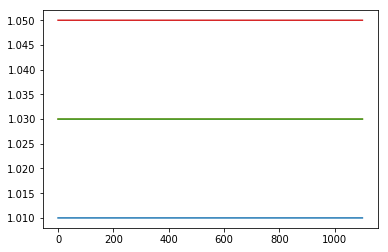

In [39]:
x = inverters[7][0].loc['VBP']

print(x[0].shape)

y=np.zeros([len(x),x[0].shape[0]])

print(y.shape)

for i in range(len(x)):
    y[i,:] = x[i]

plt.plot(y)

# Implementation of DDPG

In [9]:
import tensorflow as tf
#Tensorflow GPU optimization
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
import sys
sys.path.append('C:\\Users\\Toan Ngo\\Documents\\GitHub\\ceds-cigar\\LBNL_Simulations\\Python\\InverterStability')
from replay_buffer import ReplayBuffer

BUFFER_SIZE = 1000
BATCH_SIZE = 2
GAMMA = 0.99
TAU = 0.001 
LRA = 0.0001    
LRC = 0.001     

action_dim = 4  
state_dim = (60,3)

actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
buffer = ReplayBuffer(BUFFER_SIZE)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 3)        0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 60, 32)       4608        input_3[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 60, 32)       8320        lstm_7[0][0]                     
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 32)           8320        lstm_8[0][0]                     
__________________________________________________________________________________________________
input_4 (I

In [11]:
critic.model.output

<tf.Tensor 'dense_6/add:0' shape=(?, 1, 1) dtype=float32>

In [8]:
import numpy as np
import math
from keras.initializers import normal, identity, uniform
from keras.models import model_from_json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Lambda, Activation, LSTM, Concatenate, Add
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

############ ACTOR ############
###############################
class ActorNetwork(object):
    def __init__(self, sess, state_dim, action_dim, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network(state_dim, action_dim)   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_dim, action_dim) 
        self.action_gradient = tf.placeholder(tf.float32,[None, 1, action_dim])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.global_variables_initializer())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self, state_dim, action_dim):
        model = Sequential()
        S = Input(shape=state_dim)   
        h0 = LSTM(32, return_sequences=True)(S)
        h1 = LSTM(32, return_sequences=True)(h0)
        h2 = LSTM(32)(h1)
        V = Dense(action_dim, activation='sigmoid')(h2)
        model = Model(inputs=S,outputs=V)
        return model, model.trainable_weights, S

#######################################
class CriticNetwork(object):
    def __init__(self, sess, state_dim, action_dim, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        self.action_dim = action_dim
        
        K.set_session(sess)

        #Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_dim, action_dim)  
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_dim, action_dim)  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.global_variables_initializer())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_dim, action_dim):
        S = Input(shape=state_dim)  
        A = Input(shape=(1,action_dim))   
           
        h0 = LSTM(32, return_sequences=True)(S)
        h1 = LSTM(32, return_sequences=True)(h0)
        h2 = LSTM(32)(h1)
        V = Dense(100, kernel_initializer='he_uniform', activation='relu')(h2)
        VA = Dense(100, kernel_initializer='he_uniform', activation='relu')(A)
        
        h = Add()([V,VA])    
        h3 = Dense(50, kernel_initializer='he_uniform', activation='relu')(h)
        V = Dense(1,activation='linear')(h3)
        model = Model(inputs=[S,A],outputs=V)
        print(model.summary())
        adam = Adam(lr=self.LEARNING_RATE)
        model.compile(loss='mse', optimizer=adam)
        return model, A, S 

D:\Apps\Anacoda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


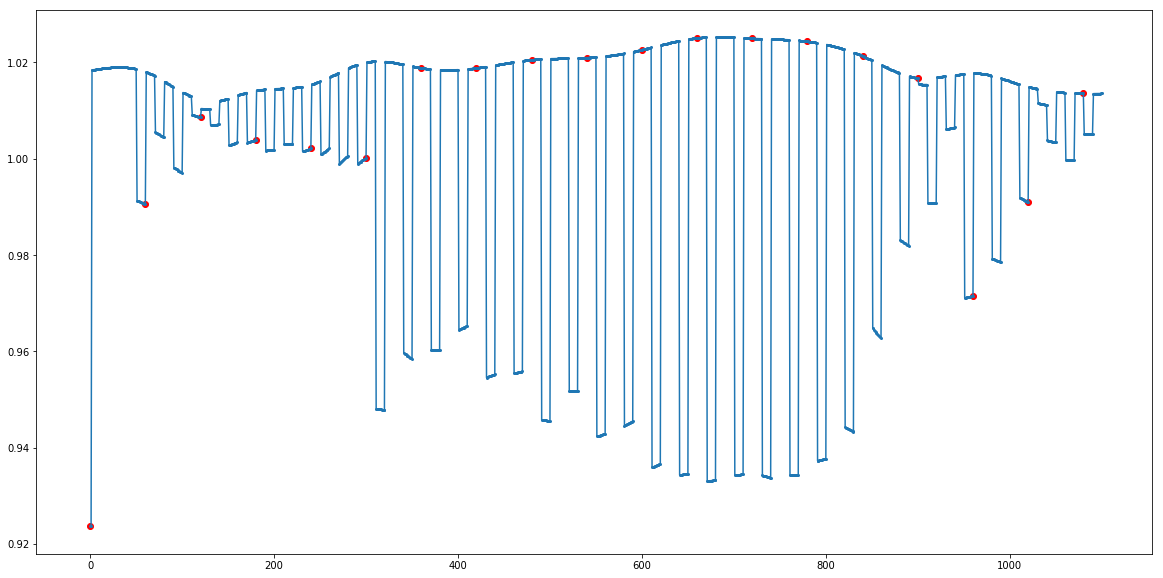

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(nodes[7].loc['Voltage'], marker='o',  markersize=2)
ax.scatter(list(range(0,TotalTimeSteps,60)) ,nodes[7].loc['Voltage'][0::60], marker='o', color='red')
plt.show()

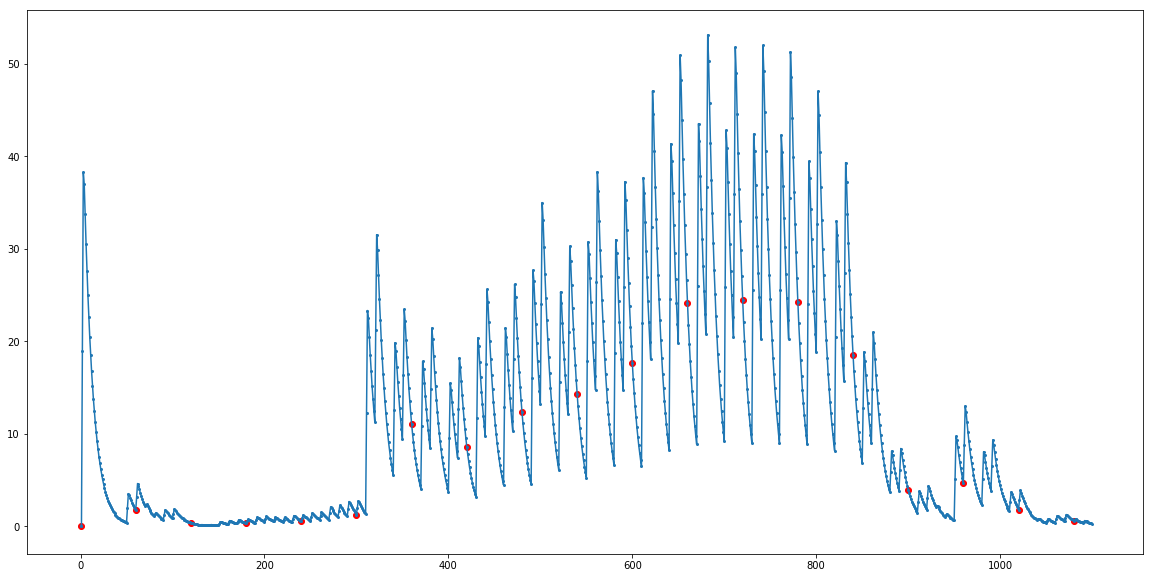

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(inverters[7][0].loc['yk'], marker='o', markersize=2)
ax.scatter(list(range(0,TotalTimeSteps,60)) ,inverters[7][0].loc['yk'][0::60], marker='o', color='red')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 20)                1760      
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 60, 20)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 60, 1)             88        
Total params: 1,848
Trainable params: 1,848
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
85/85 [==============================] - 3s 37ms/step - loss: 0.5751
Epoch 2/500
85/85 [==============================] - 1s 7ms/step - loss: 0.3164
Epoch 3/500
85/85 [==============================] - 1s 7ms/step - loss: 0.1541
Epoch 4/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0386
Epoch 5/500
85/85 [==============================] - 1s 7ms/step - loss: 0.010

85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 337/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 338/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 339/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 340/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 341/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 342/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 343/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 344/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 345/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 346/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 347/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 348/500
85/85 [=========

85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 437/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 438/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 439/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 440/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 441/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 442/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 443/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 444/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 445/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 446/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 447/500
85/85 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 448/500
85/85 [=========

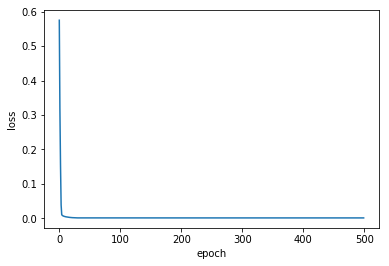

In [55]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.models import Sequential, Model

m = Sequential()
m.add(LSTM(20, input_shape=(60, 1)))
m.add(RepeatVector(60))
m.add(LSTM(1, return_sequences=True))

encoder = Model(m.layers[0].input, m.layers[0].output)

x = Input(shape=(20,))
decoded = m.layers[1](x)
#decoded = m.layers[2](decoded)
decoder = Model(x, decoded)

print(m.summary())
m.compile(loss='mse', optimizer='adam')
history = m.fit(s, s, epochs=500, batch_size = 5, verbose = 1, shuffle=True)
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


D:\Apps\Anacoda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

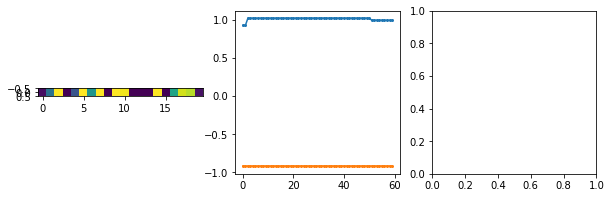

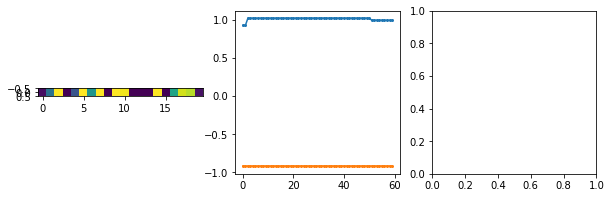

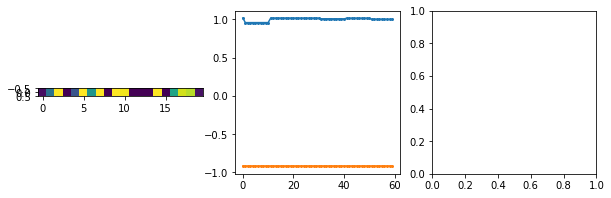

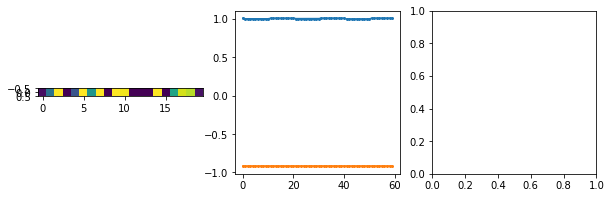

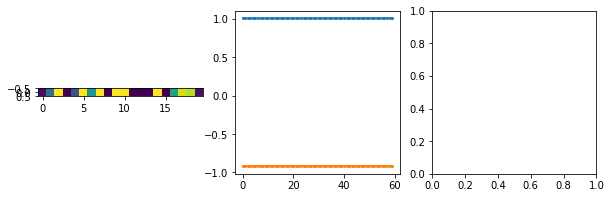

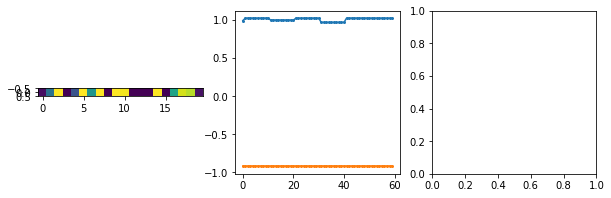

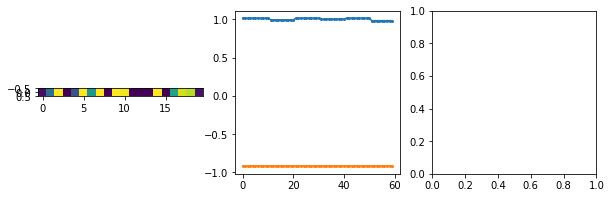

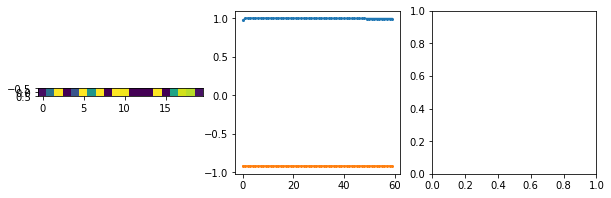

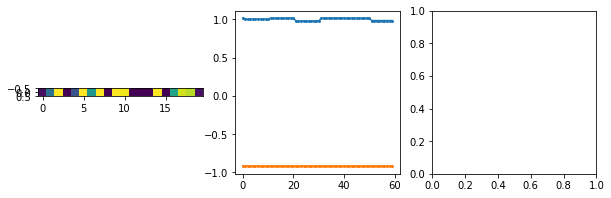

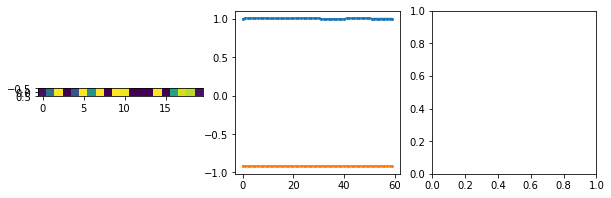

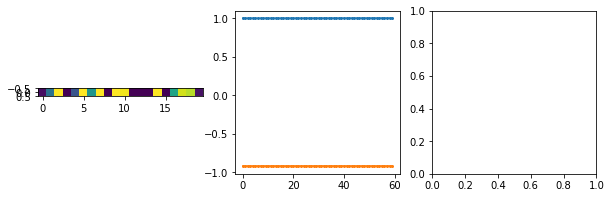

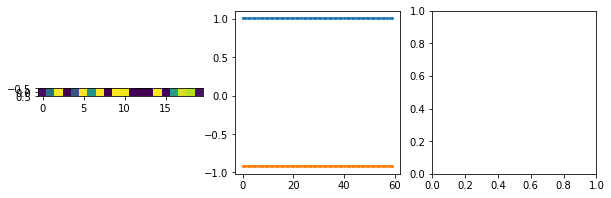

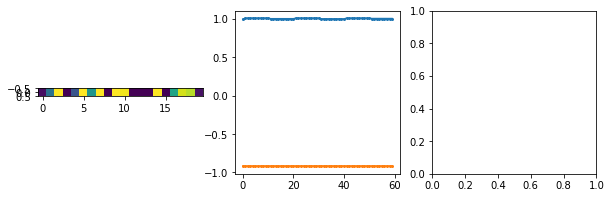

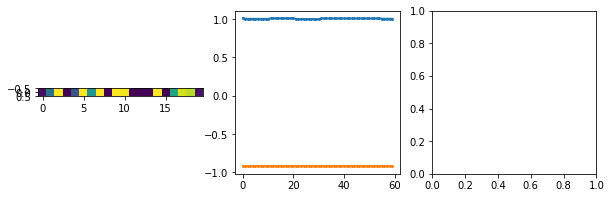

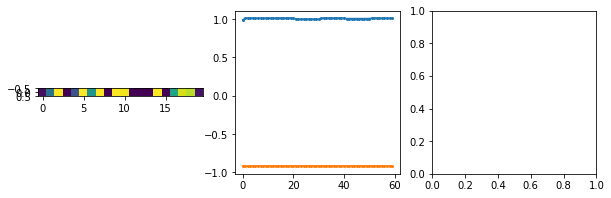

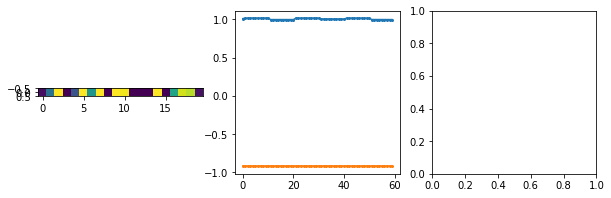

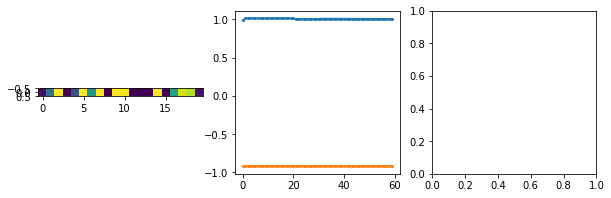

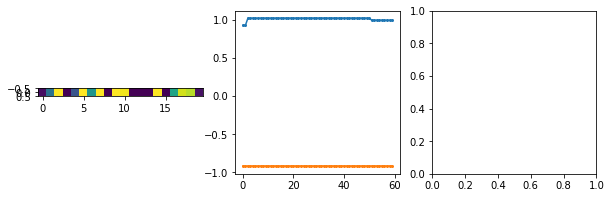

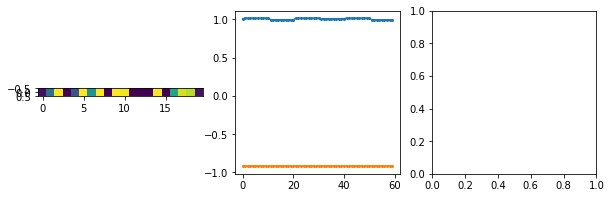

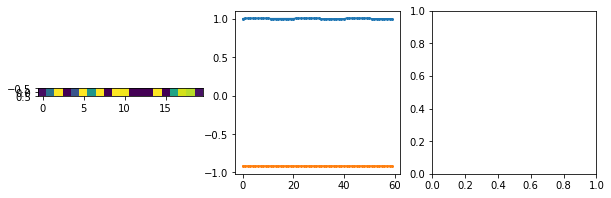

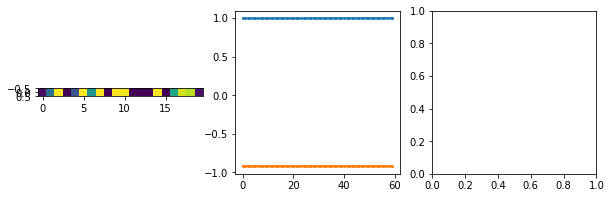

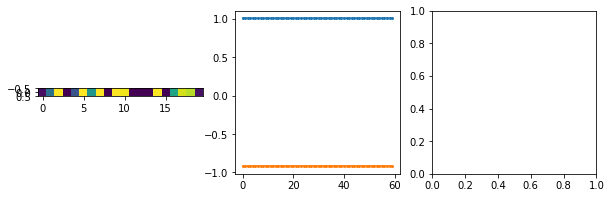

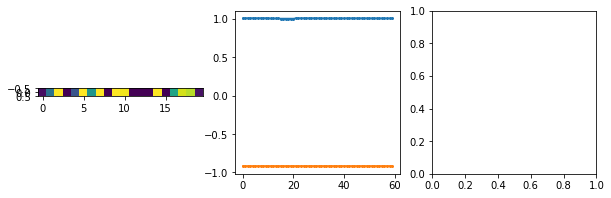

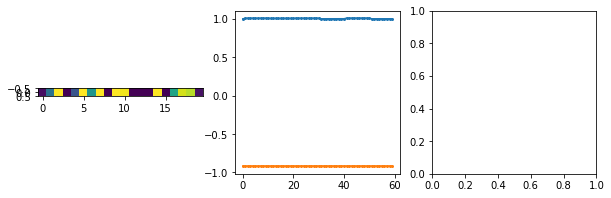

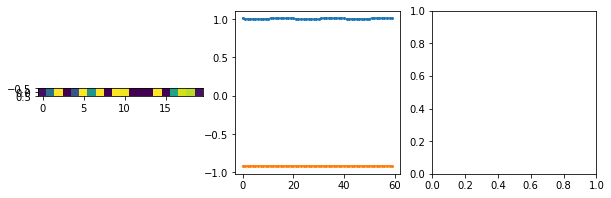

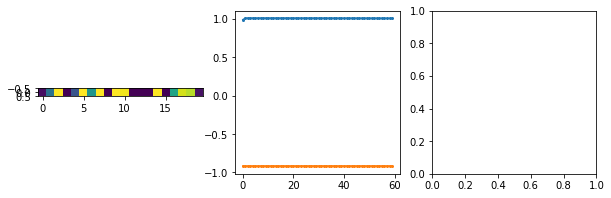

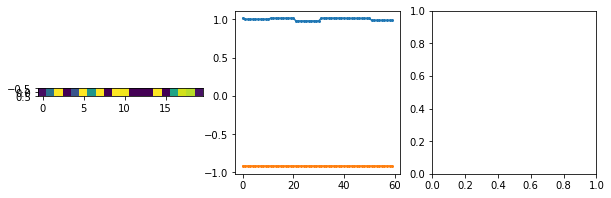

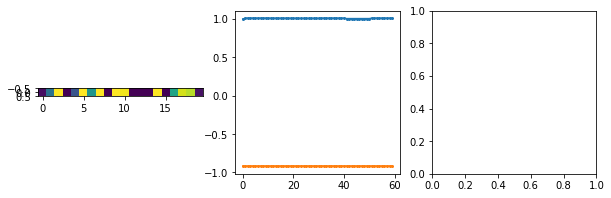

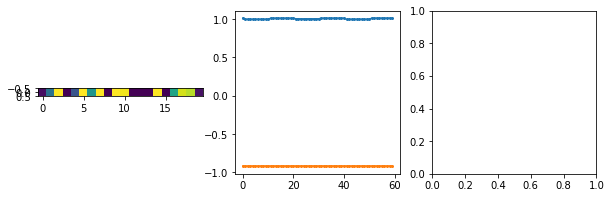

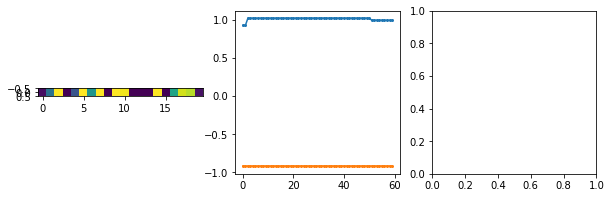

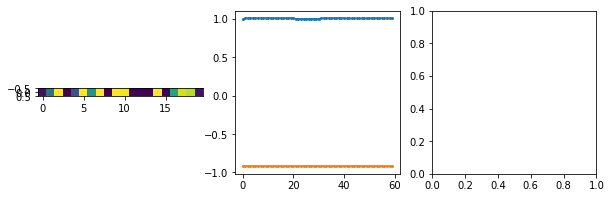

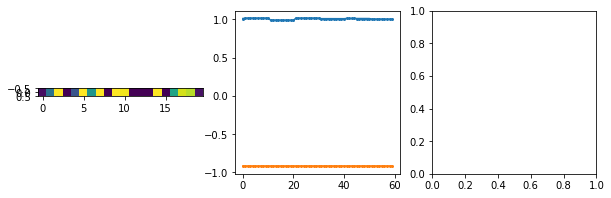

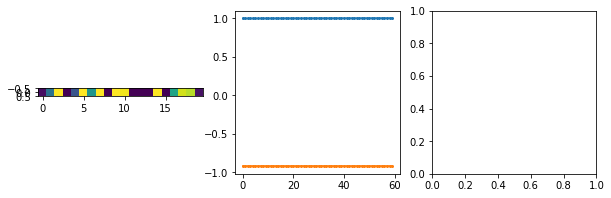

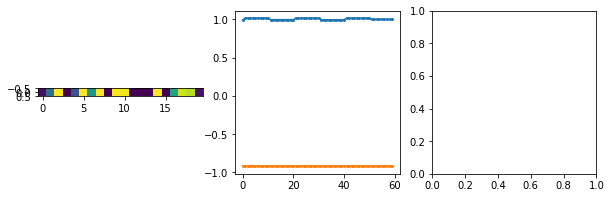

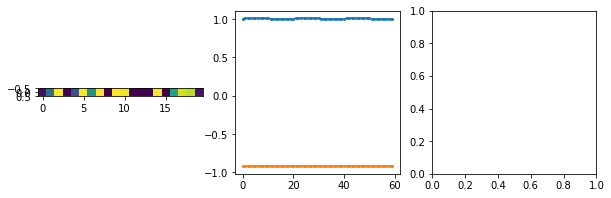

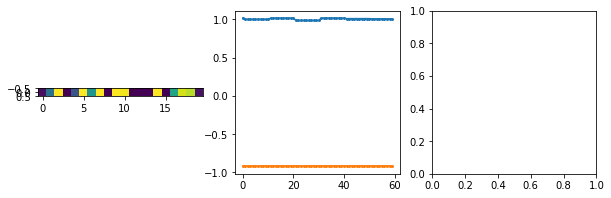

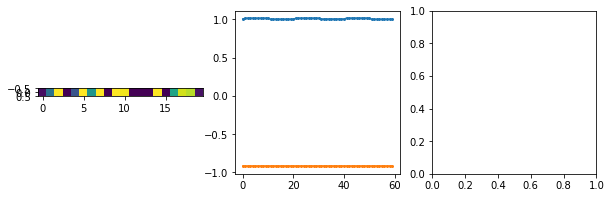

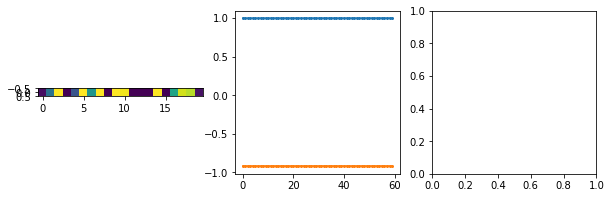

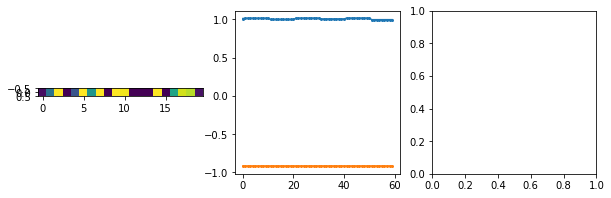

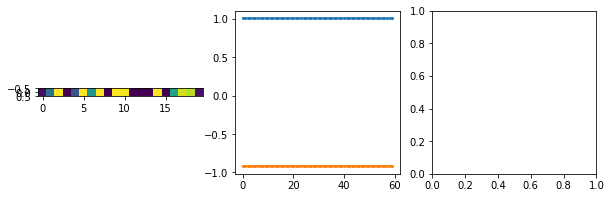

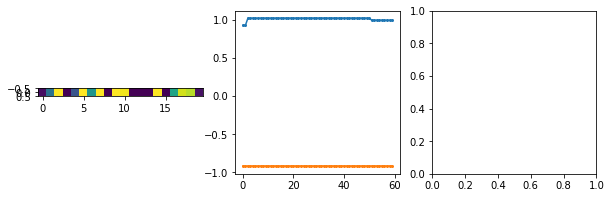

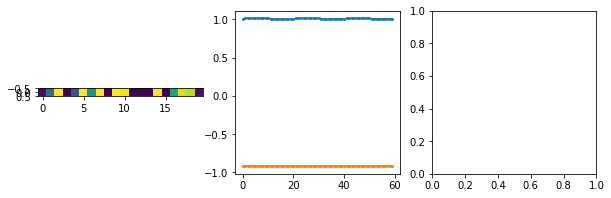

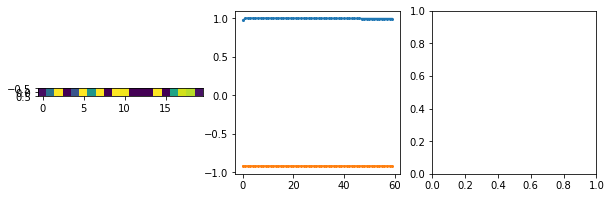

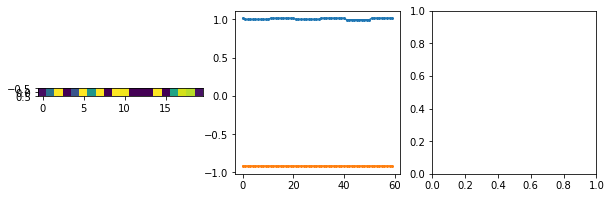

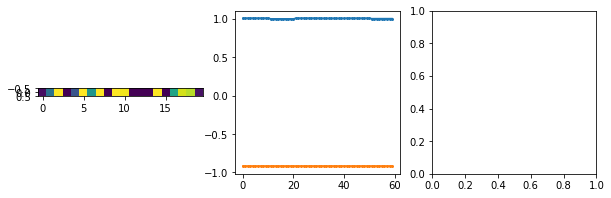

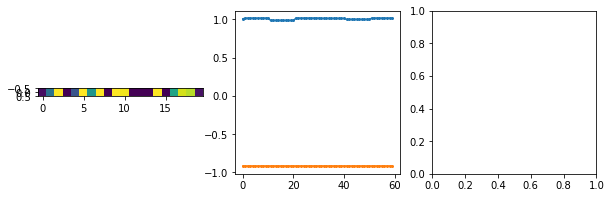

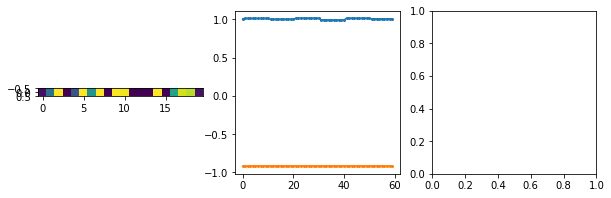

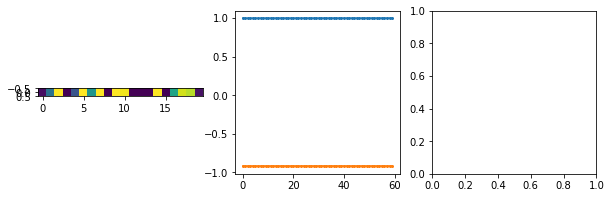

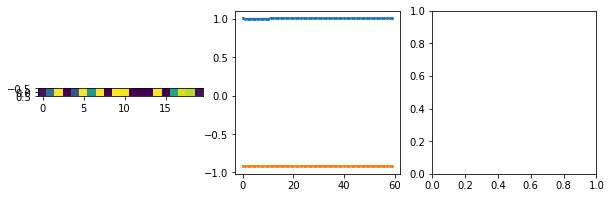

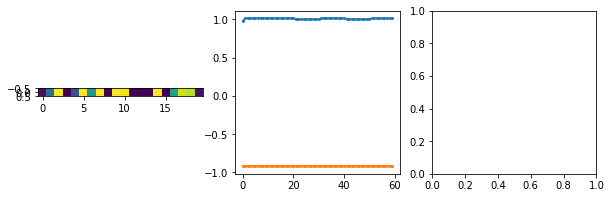

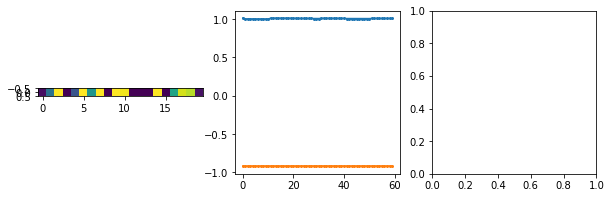

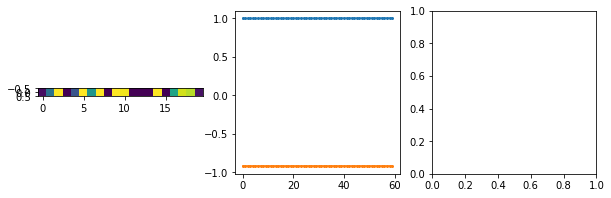

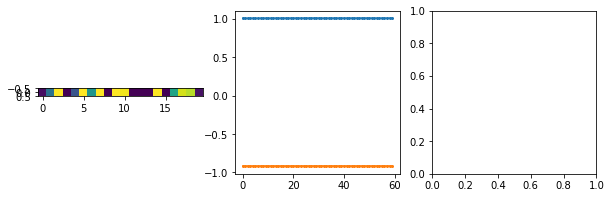

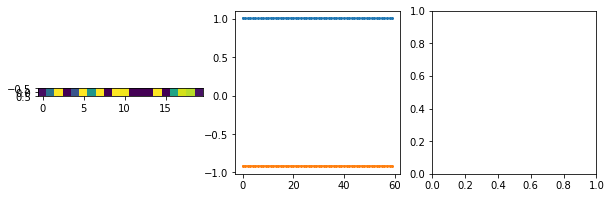

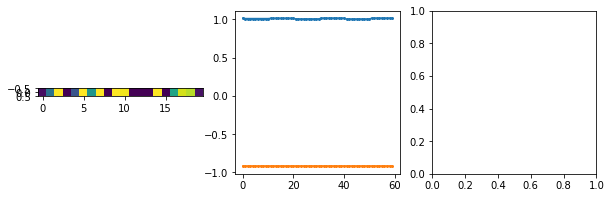

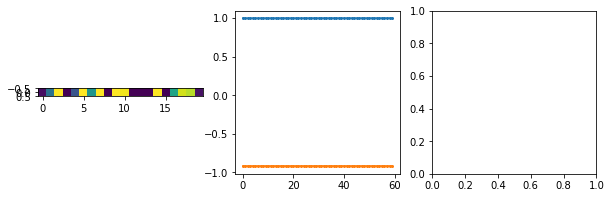

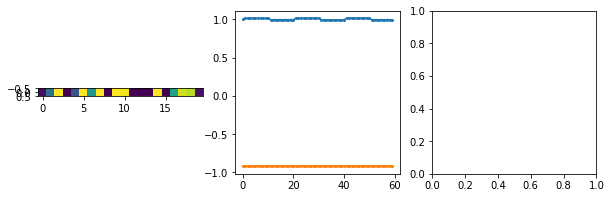

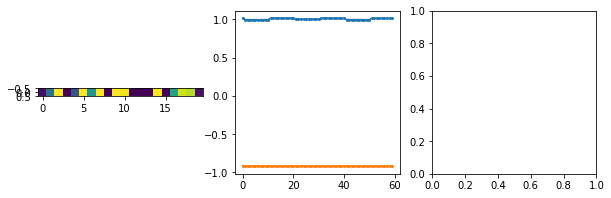

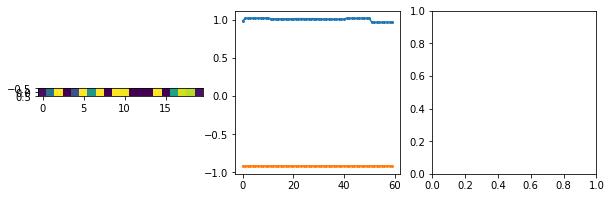

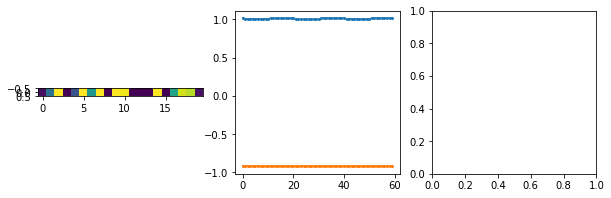

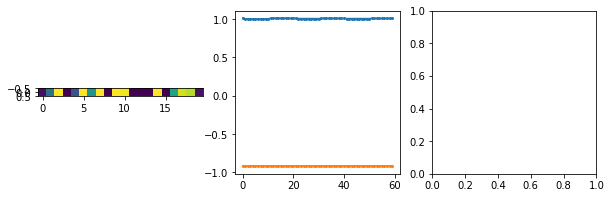

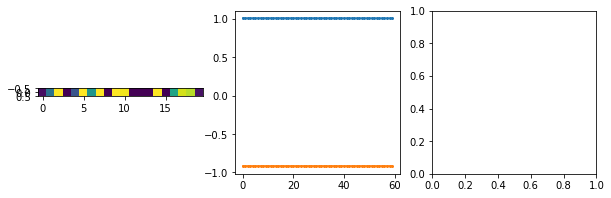

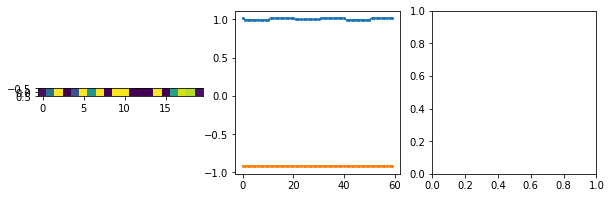

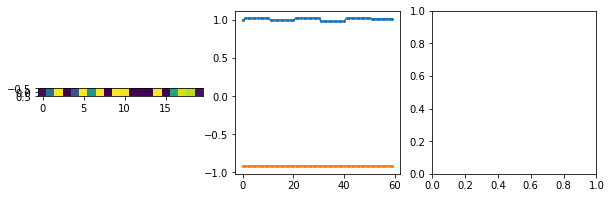

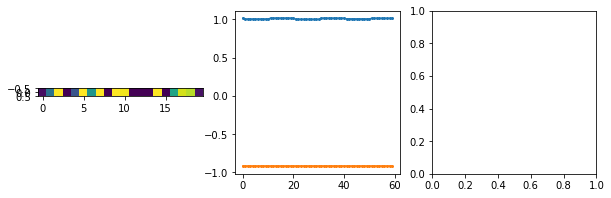

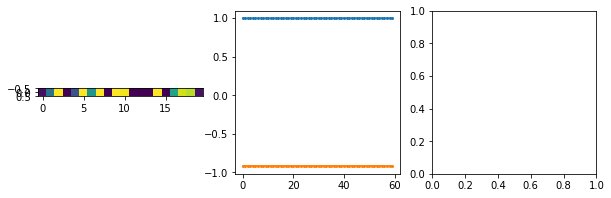

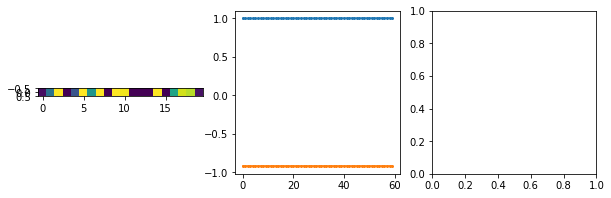

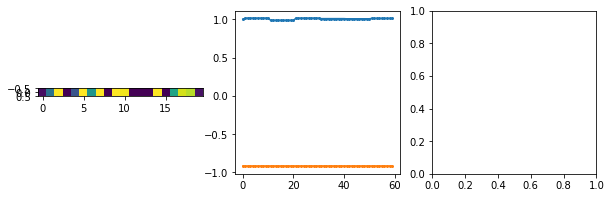

In [ ]:
hii = encoder.predict(s)
haa = decoder.predict(hii)
for i in range(len(hii)):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=([10,3]))
    ax[0].imshow(hii[i].reshape((1, 20)))
    ax[1].plot(s[i][:,0], marker='o',  markersize=2)
    ax[1].plot(haa[i][:,0], marker='o',  markersize=2)
    #ax[2].plot(s[i][:,1], marker='o',  markersize=2)
    #ax[2].plot(haa[i][:,1], marker='o',  markersize=2)